# 1. Setting the environment and importing the libraries

In [17]:
# Import libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image # Pillow for loading PNG images
import random # For randomizing selected images

# 2. Path configuration

In [18]:
current_notebook_dir = os.getcwd()
project_root_dir = os.path.abspath(os.path.join(current_notebook_dir, '..'))

BASE_DATA_DIR = os.path.join(project_root_dir, 'data')
IMAGE_DIR = os.path.join(BASE_DATA_DIR, 'images')
MASK_DIR = os.path.join(BASE_DATA_DIR, 'masks')
# -------------------------------------------------------------------

print(f"Image path: {IMAGE_DIR}")
print(f"Mask path: {MASK_DIR}")

## Check if path exists
if not os.path.exists(IMAGE_DIR):
    print(f"Error: Directory with images doesn't exist: {IMAGE_DIR}")
if not os.path.exists(MASK_DIR):
    print(f"Error: Directory with masks doesn't exist: {MASK_DIR}")
else:
    print("Directories with images and mask succesfully found.")

Image path: c:\Users\srksm\OneDrive\Desktop\lung_segmentation_project\data\images
Mask path: c:\Users\srksm\OneDrive\Desktop\lung_segmentation_project\data\masks
Directories with images and mask succesfully found.


# 3. Function for 1 sample visualization

In [19]:
def visualize_sample(image_path, mask_path):
    """
    Loading and showing the original image and its segmentation mask.
    """
    try:
        # Using 'L' for grayscale mode.
        image = Image.open(image_path).convert('L')
        mask = Image.open(mask_path).convert('L')

        image_np = np.array(image)
        mask_np = np.array(mask)

        # Mask binarization
        mask_np[mask_np > 0] = 1
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))

        # 1. Original image
        axes[0].imshow(image_np, cmap='gray')
        axes[0].set_title(f'Original Image\n({os.path.basename(image_path)})')
        axes[0].axis('off')

        # 2. Binary segmentation mask
        axes[1].imshow(mask_np, cmap='gray')
        axes[1].set_title(f'Binary Segmentation Mask')
        axes[1].axis('off')

        # 3. Mask overlapped on original image
        axes[2].imshow(image_np, cmap='gray')
        # Using blue color for lungs
        axes[2].imshow(mask_np, cmap='Blues', alpha=0.4)
        axes[2].set_title('Lungs (blue) overlapped')
        axes[2].axis('off')

        plt.tight_layout()
        plt.show()

    except FileNotFoundError:
        print(f"Error: File not found. Check the paths: {image_path} ili {mask_path}")
    except Exception as e:
        print(f"Error with visualization of one sample: {e}")

# 4. Overview of Random Samples


\Overiew of 5 random samples:


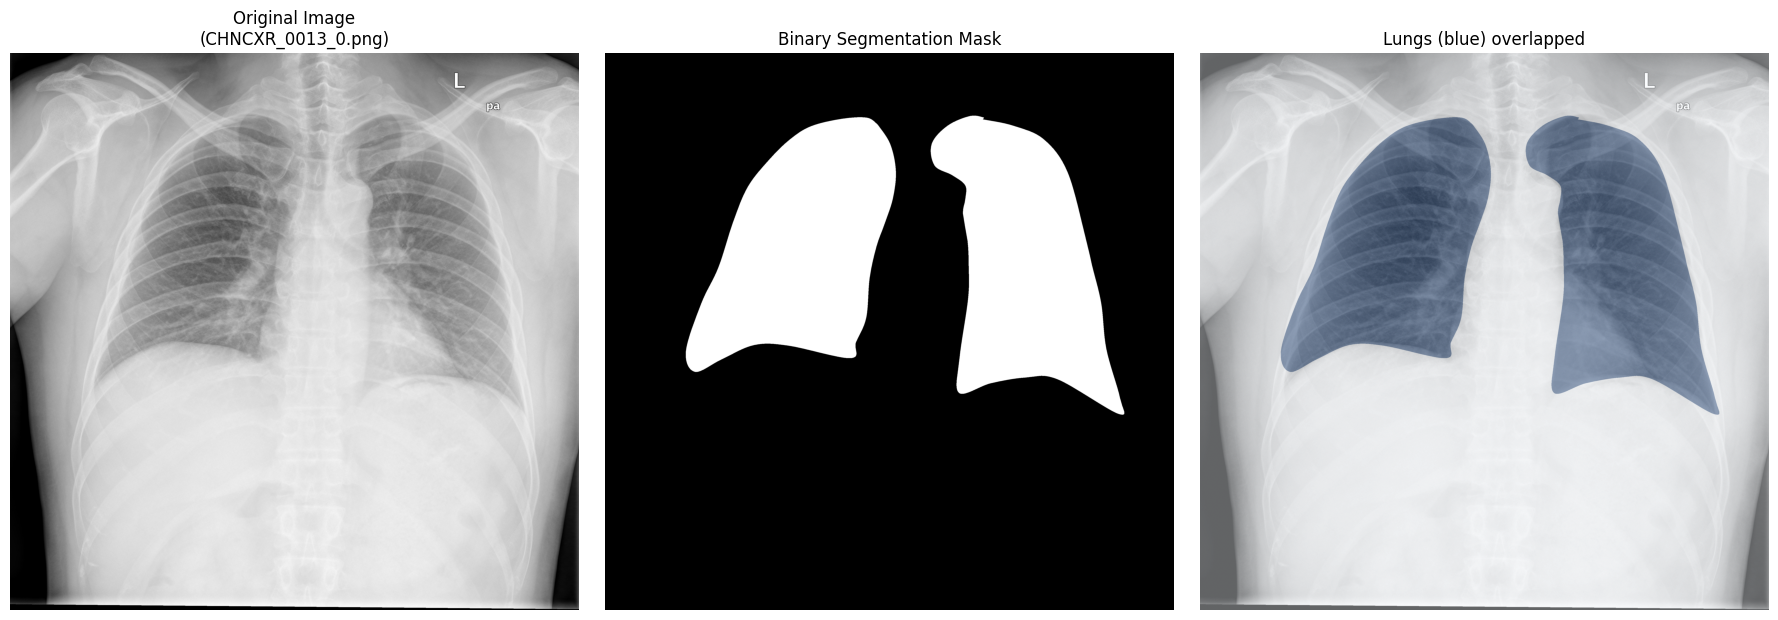

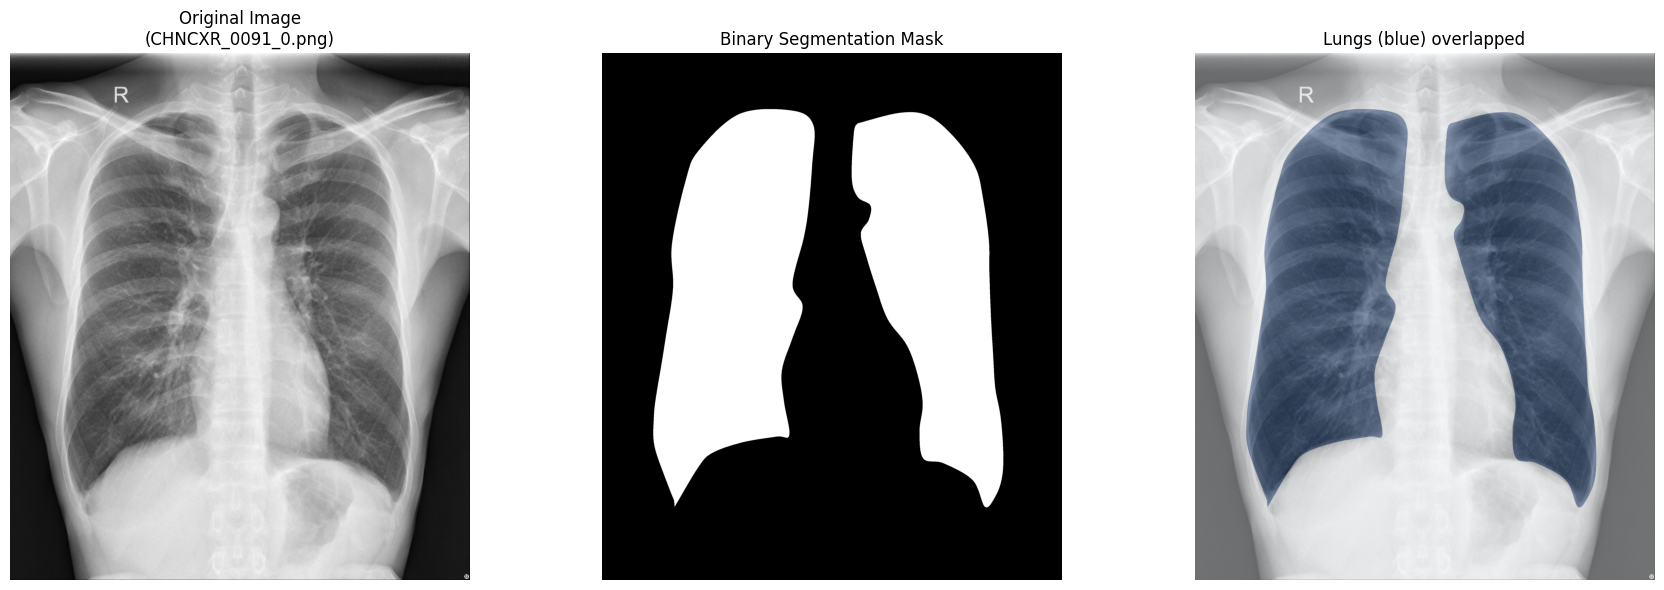

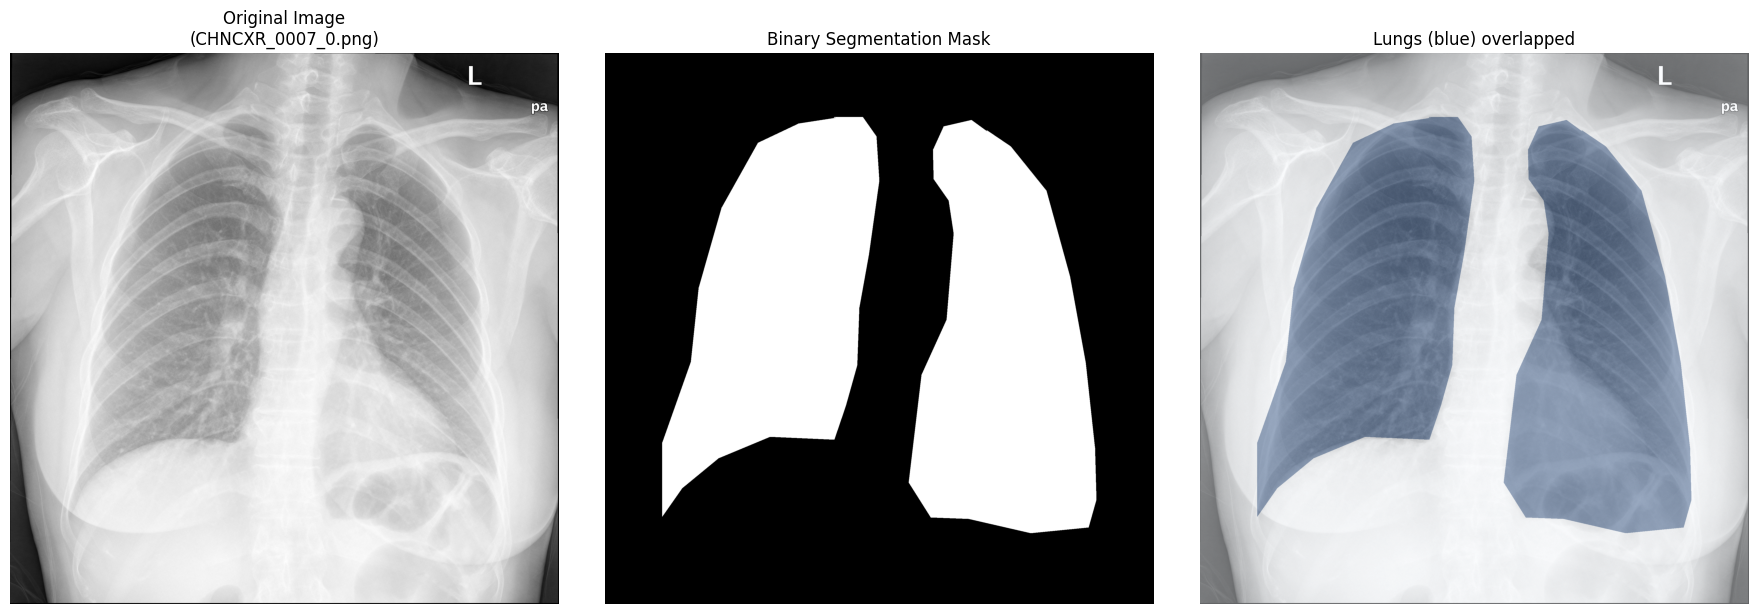

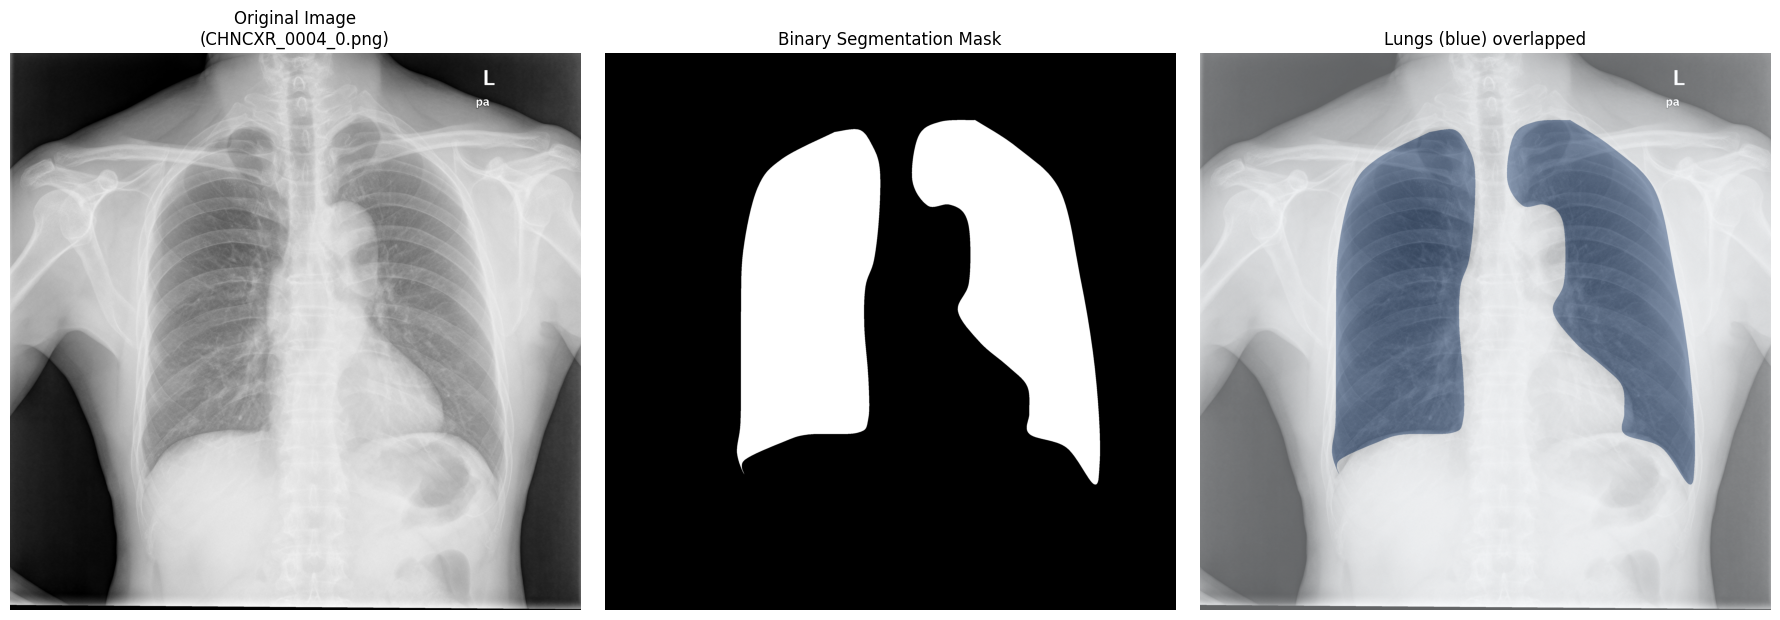

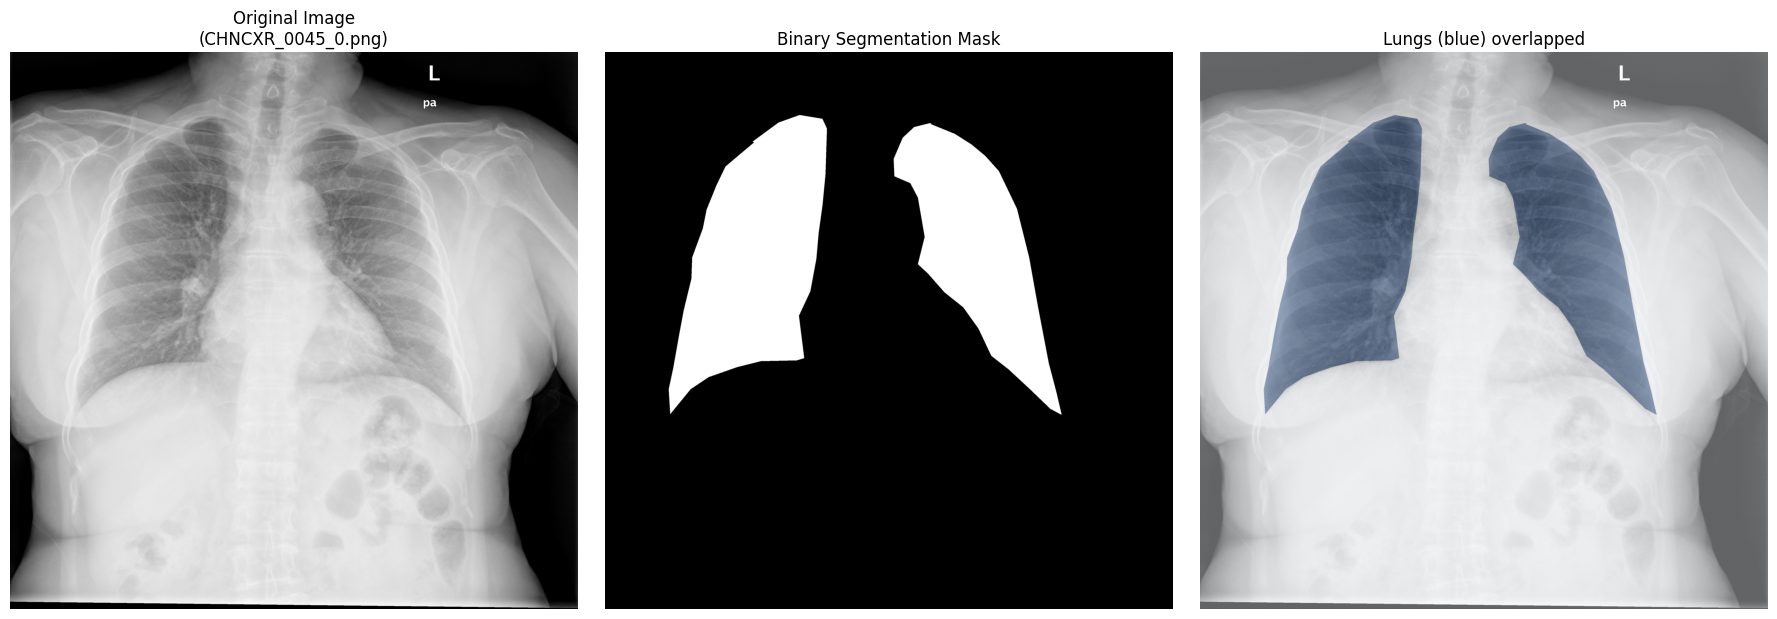

In [20]:
image_filenames = sorted(os.listdir(IMAGE_DIR))
mask_filenames = sorted(os.listdir(MASK_DIR))

if not image_filenames or not mask_filenames:
    print("There is no images or masks in named directory. Check the path and contain of the directory.")
else:
    paired_files = []
    for img_name in image_filenames:
        base_name, ext = os.path.splitext(img_name)
        mask_name = f"{base_name}_mask{ext}" # logic for correct pairing of the names

        img_path = os.path.join(IMAGE_DIR, img_name)
        mask_path = os.path.join(MASK_DIR, mask_name)

        if os.path.exists(mask_path):
            paired_files.append((img_name, mask_name))
        else:
            print(f"Warning: Mask '{mask_name}' isn't found for image '{img_name}'. Skipping.")

    if not paired_files:
        print("There is no any pair of image and mask for visualization.")
    else:
        num_samples_to_visualize = min(5, len(paired_files)) 
        random_samples = random.sample(paired_files, num_samples_to_visualize)

        print(f"\nOverview of {num_samples_to_visualize} random samples:")
        for img_name, mask_name in random_samples:
            img_path = os.path.join(IMAGE_DIR, img_name)
            mask_path = os.path.join(MASK_DIR, mask_name)
            visualize_sample(img_path, mask_path)

# 5. Function for Statistic Analysis of the Dataset


In [21]:

def analyze_dataset_statistics(image_dir, mask_dir):
    image_filenames = sorted(os.listdir(image_dir))
    
    resolutions = []
    lung_pixel_ratios = [] 

    print(f"\n--- Starting the statistic analysis for {len(image_filenames)} image ---")

    # Creating list of paires (image_name, mask_name)
    paired_files_for_stats = []
    for img_name in image_filenames:
        base_name, ext = os.path.splitext(img_name)
        mask_name = f"{base_name}_mask{ext}"

        mask_path_check = os.path.join(mask_dir, mask_name)
        if os.path.exists(mask_path_check):
            paired_files_for_stats.append((img_name, mask_name))
        else:
            pass 

    if not paired_files_for_stats:
        print("There is no any pair of image and mask for statistic analysis.")
        return

    for i, (img_name, mask_name) in enumerate(paired_files_for_stats):
        img_path = os.path.join(image_dir, img_name)
        mask_path = os.path.join(mask_dir, mask_name)

        try:
            image = Image.open(img_path).convert('L') 
            mask = Image.open(mask_path).convert('L')   

            # Resolution
            width, height = image.size
            resolutions.append((width, height))

            # Balance class (pixel ratio lungs vs. background)
            mask_np = np.array(mask)
            mask_np[mask_np > 0] = 1 

            total_pixels = mask_np.size
            lung_pixels = np.sum(mask_np == 1)

            if total_pixels > 0:
                lung_pixel_ratio = lung_pixels / total_pixels
                lung_pixel_ratios.append(lung_pixel_ratio)
            else:
                print(f"Warning: Image '{img_name}' has 0 pixels. Skipping the class balance.")

        except Exception as e:
            print(f"Error while analyzing '{img_name}' for statistic: {e}")
            continue

    print("\n--- Resolution Statistics ---")
    if resolutions:
        resolutions_np = np.array(resolutions)
        unique_resolutions = np.unique(resolutions_np, axis=0)

        print(f"Total number of images analized for resolution: {len(resolutions)}")
        print(f"Number of unique resolutions: {len(unique_resolutions)}")
        print("Unique resolutions:")
        for res in unique_resolutions:
            print(f"  - {res[0]}x{res[1]}")

        print(f"Min resolution: {np.min(resolutions_np[:, 0])}x{np.min(resolutions_np[:, 1])}")
        print(f"Max resolution: {np.max(resolutions_np[:, 0])}x{np.max(resolutions_np[:, 1])}")
        print(f"Average resolution: {np.mean(resolutions_np[:, 0]):.2f}x{np.mean(resolutions_np[:, 1]):.2f}")
    else:
        print("There is no data about resolution.")

    print("\n--- Balance Class Statistics (Lung pixel ratio) ---")
    if lung_pixel_ratios:
        lung_pixel_ratios_np = np.array(lung_pixel_ratios)
        print(f"Total number of images analized for class balance: {len(lung_pixel_ratios)}")
        print(f"Min lung pixel ratio: {np.min(lung_pixel_ratios_np):.4f}")
        print(f"Max lung pixel ratio: {np.max(lung_pixel_ratios_np):.4f}")
        print(f"Average lung pixel ratio: {np.mean(lung_pixel_ratios_np):.4f}")
        print(f"Median lung pixel ratio: {np.median(lung_pixel_ratios_np):.4f}")

        plt.figure(figsize=(10, 6))
        plt.hist(lung_pixel_ratios_np * 100, bins=20, edgecolor='black')
        plt.title('Percentage Distribution of Lung Pixel Ratio per Image')
        plt.xlabel('Lung Pixels Percentage (%)')
        plt.ylabel('Number of Images')
        plt.grid(axis='y', alpha=0.75)
        plt.show()
    else:
        print("There is no data about class balance.")


# 6. Runing the statistics


--- Starting the statistic analysis for 168 image ---

--- Resolution Statistics ---
Total number of images analized for resolution: 161
Number of unique resolutions: 110
Unique resolutions:
  - 1225x1149
  - 1233x1110
  - 1250x1136
  - 1255x989
  - 2119x2080
  - 2128x2405
  - 2227x2066
  - 2238x2946
  - 2253x1737
  - 2260x2203
  - 2271x2768
  - 2306x2320
  - 2308x2308
  - 2357x2461
  - 2365x2889
  - 2369x2942
  - 2384x2452
  - 2395x2600
  - 2407x2388
  - 2415x2804
  - 2419x2548
  - 2419x2562
  - 2443x2527
  - 2452x2947
  - 2464x2317
  - 2478x2382
  - 2486x2617
  - 2493x2957
  - 2498x2481
  - 2512x2638
  - 2516x2942
  - 2521x2959
  - 2529x2786
  - 2531x2890
  - 2536x2843
  - 2587x2968
  - 2589x2667
  - 2600x2994
  - 2602x2988
  - 2609x2489
  - 2631x2406
  - 2655x2904
  - 2674x2685
  - 2679x3001
  - 2682x2869
  - 2692x2930
  - 2697x2880
  - 2699x2927
  - 2715x2946
  - 2724x2876
  - 2730x2941
  - 2733x2731
  - 2739x2941
  - 2739x2944
  - 2751x2990
  - 2760x2555
  - 2761x2961
  - 2775x29

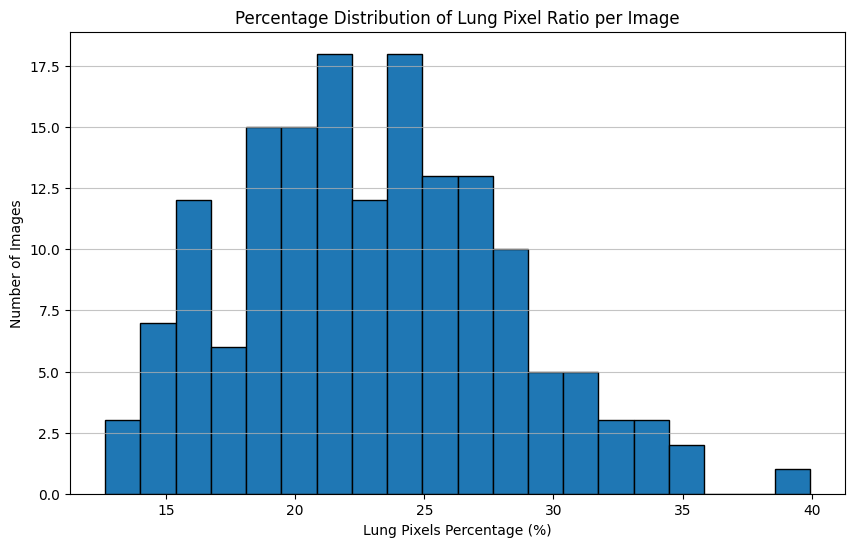

: 

In [ ]:
analyze_dataset_statistics(IMAGE_DIR, MASK_DIR)